In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

In [2]:
coaches = pd.read_csv('combined.csv')
bengals = pd.read_csv('bengals.csv')

In [3]:
ly=coaches.groupby(['name','level']).agg({'year':'count'})
ly_piv=ly.reset_index().pivot(index = 'name',columns = 'level',values='year')[['Coordinator','Head','Positional']]

In [4]:
level_record = coaches[['name','level']].drop_duplicates()

In [5]:
level_record = coaches[['name','level']].drop_duplicates()
level_record_only = (coaches.groupby(['name','level']).agg(sum).win/
                      (coaches.groupby(['name','level']).agg(sum).win + 
                       coaches.groupby(['name','level']).agg(sum).loss)).to_frame(name='wl')
lp = pd.merge(level_record,level_record_only,how='left',on = ['name','level'])
lp_pivot = lp.pivot(index='name',columns='level',values='wl')[['Coordinator','Head','Positional']]

In [6]:
lyp = pd.merge(ly,lp,how='inner',on = ['name','level'])
lyp_piv = lyp.pivot(index = 'name', columns = 'level')

In [7]:
byyr = (coaches.groupby(['year','phase']).agg({'name':'count'}).name/coaches.groupby('year').agg({'team':'nunique'}).team).to_frame(name='avg coaches').reset_index()
byyr_piv = byyr.pivot(index='year',columns = 'phase')['avg coaches'][['Defense','Offense','Special Teams']]

In [8]:
cbbyyr = bengals.groupby(['year','phase']).agg({'name':'count'}).rename(columns = {'name':'coaches'}).reset_index()
cbbyyr_piv = cbbyyr.pivot(index='year',columns = 'phase')['coaches'][['Defense','Offense','Special Teams']]
allyr_piv = pd.merge(cbbyyr_piv,byyr_piv,how='right',on=['year'],suffixes=({'_bengals','_nfl'}))

In [9]:
coach_by_yr = coaches.groupby(['year','team','phase']).agg({'name':'count'}).rename(columns={'name':'coaches'}).reset_index()
cbym = coach_by_yr.groupby(['year','phase']).agg({'coaches':'mean'}).rename(columns={'coaches':'mean'}).reset_index()
cbystd= coach_by_yr.groupby(['year','phase']).agg({'coaches':'std'}).rename(columns={'coaches':'std'}).reset_index()
tcby=pd.merge(pd.merge(cbbyyr,cbym,how = 'inner',on=['year','phase']),cbystd,how='inner',on=['year','phase'])
tcby['z']=(tcby['coaches']-tcby['mean'])/tcby['std']
tcby['p']=st.norm.cdf(tcby['z'])

C:\Users\pol\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\pol\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\pol\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1748: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


In [10]:
head_g = coaches[coaches.level == 'Head'].groupby(['name','team','level'])
head_wl = head_g.agg({'year':'count','win':'sum','loss':'sum'})
head3_ct = head_wl.loc[head_wl.year>2]
head3_ct['wl']=head_wl.win/(head_wl.win+head_wl.loss)
head3_ct = head3_ct.reset_index().rename(columns = {'year':'season'})[['name','team','wl','season']]
head3_yr = coaches[coaches.level =='Head'].groupby(['name','team','level']).agg({'year':'min'}).reset_index().rename(columns={'year':'debut'})
head3 = pd.merge(head3_ct,head3_yr,how = 'inner',on = ['name','team'])


C:\Users\pol\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [11]:
past3_m = pd.merge(head3,coaches,how='inner',on='name',suffixes=('_h','_p'))
past3_m = past3_m.loc[(past3_m.year<past3_m.debut) & (past3_m.year>past3_m.debut-4)].sort_values('year')
past3 = past3_m.groupby(['name','team_h','debut']).agg({'win':'sum','loss':'sum','position':'first',
                                                        'phase':'first','level_p':'first','team_p':'first'})
past3['wl_p']=past3.win/(past3.win+past3.loss)
past3 = past3.reset_index().rename(columns={'team_h':'team'}).drop(columns=['win','loss'])
hp3 = pd.merge(head3,past3,how='right',on=['name','team','debut'])

In [136]:
new_hc=pd.merge(head3,hp3,how='outer',on=['name','team','wl','season','level','debut'])
new_hc=new_hc[new_hc.position.isna()].reset_index().drop(columns=['index'])
new_hc = new_hc[~new_hc.wl.isna()]

In [101]:
new_hc[new_hc.wl>=0.5].name.count()/new_hc.name.count()

0.4899328859060403

In [102]:
new_hc.wl.mean()

0.48903126753630954

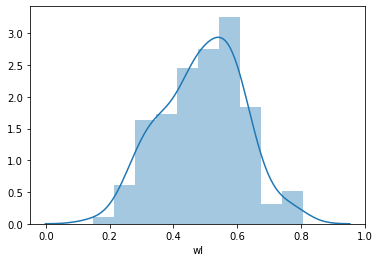

In [74]:
sns.distplot(new_hc.wl)

In [85]:
hp3_nona = hp3[~hp3.wl.isna()]

In [100]:
hp3_nona[hp3_nona.wl>=0.5].name.count()/hp3_nona.name.count()

0.4842105263157895

In [103]:
hp3_nona.wl.mean()

0.4796947042921246

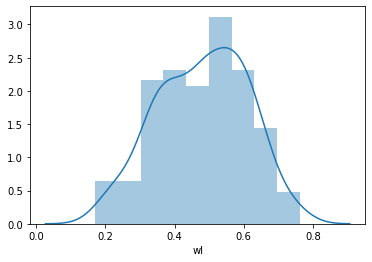

In [86]:
sns.distplot(hp3_nona.wl)

In [106]:
head_head=hp3[hp3.level_p == 'Head']

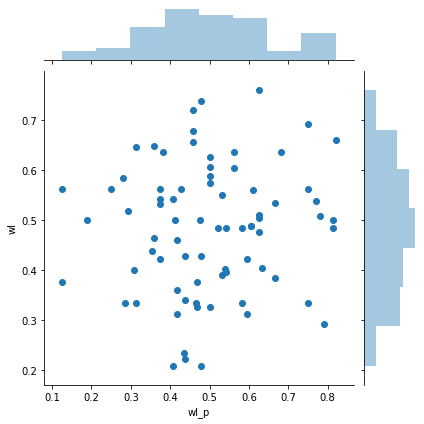

In [108]:
sns.jointplot(x='wl_p',y='wl',data = head_head)

In [113]:
head_head[(head_head.wl>=0.5) & (head_head.wl_p>=0.5)].name.count()

19

In [114]:
head_head.name.count()

76

In [115]:
head_head[(head_head.wl<0.5) & (head_head.wl_p>=0.5)].name.count()

18

In [117]:
head_head[(head_head.wl>=0.5) & (head_head.wl_p<0.5)].name.count()

19

In [118]:
head_head[(head_head.wl<0.5) & (head_head.wl_p<0.5)].name.count()

20

In [137]:
head2 = head_wl[head_wl.year<3]
head2['wl']=head2.win/(head2.win+head2.loss)
head2 = head2.reset_index()

C:\Users\pol\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [133]:
head2[head2.wl>=0.5].name.count()/head2.name.count()

0.34539473684210525

In [135]:
head2[head2.wl>=0.6]

,name,team,level,year,win,loss,wl
2,Al Saunders,St. Louis Rams,Head,2,23.0,9.0,0.718750
4,Alex Gibbs,Atlanta Falcons,Head,1,11.0,5.0,0.687500
7,Andre Tucker,Chicago Bears,Head,1,12.0,4.0,0.750000
9,Anthony Lynn,Los Angeles Chargers,Head,2,21.0,11.0,0.656250
21,Bill Musgrave,Atlanta Falcons,Head,1,13.0,3.0,0.812500
22,Bill Nayes,Los Angeles Rams,Head,2,24.0,8.0,0.750000
24,Bob Babich,Chicago Bears,Head,1,13.0,3.0,0.812500
26,Bob Slowik,Green Bay Packers,Head,2,22.0,10.0,0.687500
29,Brad Childress,Kansas City Chiefs,Head,1,10.0,6.0,0.625000
30,Bret Bielema,New England Patriots,Head,1,11.0,5.0,0.687500


In [12]:
# relationship = dict()
# names = sorted(coaches.name.dropna().unique())
# for name in names:
#     related = related_to(name)
#     relationship[name] = related


def related_to(name):
    beenhere = coaches.loc[coaches.name == name][['team','year']]
    beenhere.reset_index(inplace =True)
    firsthand = set()
    for teamyear in range(len(beenhere)):
        (i,j) = beenhere.loc[teamyear,['team','year']]
        [firsthand.add(person) for person in coaches.loc[(coaches.team == i)&(coaches.year==j)].name.tolist()]
    firsthand.remove(name)
    return firsthand 

def worked_at(name_list):
    timespace = set()
    for name in name_list:
        beenhere = coaches.loc[coaches.name == name][['team','year']]
        beenhere.reset_index(inplace = True)
        for teamyear in range(len(beenhere)):
            (i,j) = beenhere.loc[teamyear,['team','year']]
            timespace.add((i,j))
    return timespace

In [13]:
def are_related(kevin, bacon, degree = None):
    newset=set()
    subt=set()

    if degree!=None:
        deglen=len(degree)

        degree=degree + [set()]
        timeyr = worked_at(degree[deglen-1])
        for (i,j) in timeyr:
            [newset.add(person) for person in coaches.loc[(coaches.team == i)&(coaches.year==j)].name.tolist()]

            if bacon in newset:
                print(deglen)
                print(i,' ',j)
#                 print(type(degree))
                return deglen
            else:
                degree[deglen] = degree[deglen]|newset
#                 print(len(newset), ' ',i,' ',j)
                newset=set()
            

        for i in range(0,deglen):
            subt = subt|degree[i]

        newset= newset-subt
        if newset== None:
            return 'No Connection'

        are_related(kevin, bacon, degree)
    else:
        deglen = 0
        if kevin == bacon:
            return deglen
        else:
            degree = [{kevin}]
            deglen = are_related(kevin, bacon, degree)
            return deglen




# NFL Coaches

Sources:  wikipedia.com, pro-football-reference.com

Additionally:  gb.packers.com, bengals.com

### Phases of Game

##### Offense

##### Defense

##### Special Teams

### Levels of Coaching

##### Head Coach

##### Coordinator: Offensive/Defensive Coordinators, Assistant/Associate Head Coach, Special Teams Coach

##### Positional Coaches: includes groups of positions e.g. Secondary Coach, Offensive Line Coach


## Coaches by Year

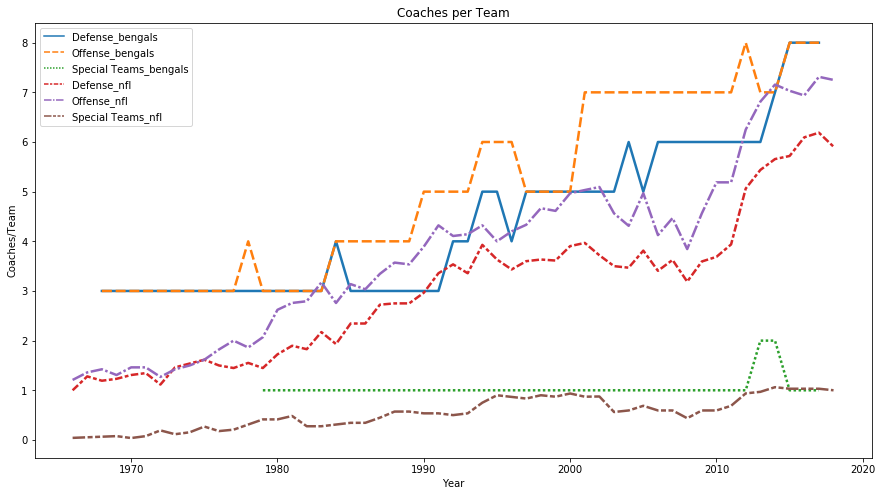

In [14]:
plt.figure(figsize=(15,8))
no_coach = sns.lineplot(data=allyr_piv, linewidth=2.5)
no_coach.set(xlabel='Year', ylabel='Coaches/Team')
no_coach.set_title('Coaches per Team')
plt.show()

In [15]:
tcby.loc[(tcby.p>0.95)]

,year,phase,coaches,mean,std,z,p
0,1968.0,Defense,3,1.722222,0.669113,1.909659,0.971911
9,1971.0,Defense,3,1.750000,0.716350,1.744956,0.959504
52,1984.0,Defense,4,2.434783,0.945135,1.656078,0.951147
91,1994.0,Offense,6,4.481481,0.802418,1.892428,0.970783


In [16]:
lyp.groupby('level').agg({'name':'count','year':['mean','median'],'wl':['mean','median']})

name      year               wl          
            count      mean median      mean    median
level                                                 
Coordinator   318  3.805031      2  0.487496  0.487603
Head          439  5.275626      4  0.455144  0.468750
Positional   1623  6.088108      4  0.478641  0.484375

## Years in Levels of Coaching

#### Coordinator vs Positional

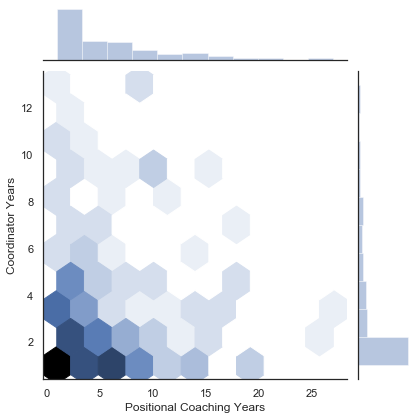

In [17]:

sns.set(style="white")
cvp_yr = sns.jointplot(x='Positional', y='Coordinator', data= ly_piv, kind = 'hexa')
cvp_yr.set_axis_labels(xlabel='Positional Coaching Years', ylabel='Coordinator Years')
plt.show()

#### Head Coach vs Coordinator

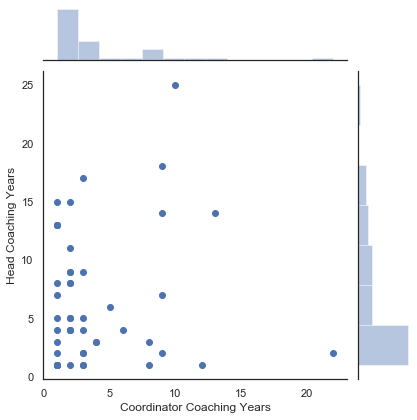

In [18]:
hvc_yr = sns.jointplot(x='Coordinator', y='Head', data= ly_piv)
hvc_yr.set_axis_labels(xlabel='Coordinator Coaching Years', ylabel='Head Coaching Years')
plt.show()

#### Head Coach vs Positional

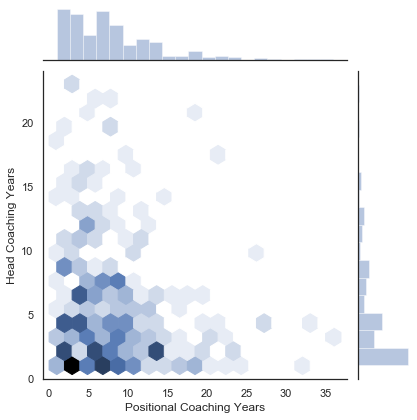

In [19]:
hvp_yr = sns.jointplot(x='Positional', y='Head', data= ly_piv, kind = 'hexa')
sns.set(style="white")
hvp_yr.set_axis_labels(xlabel = 'Positional Coaching Years', ylabel='Head Coaching Years')
plt.show()

## Longevity at each Level

#### Positional Coach Year vs Winnig Ratio

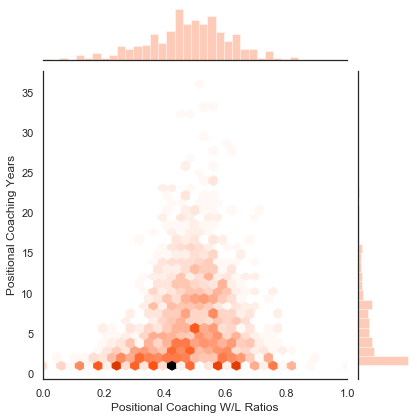

In [20]:
wvy_pp = sns.jointplot(x=lyp_piv.wl.Positional, y=lyp_piv.year.Positional, kind = 'hexa',xlim=(0,1), color = 'coral')
wvy_pp.set_axis_labels(xlabel = 'Positional Coaching W/L Ratios', ylabel='Positional Coaching Years')
plt.show()

#### Coordinator Year vs Winnig Ratio

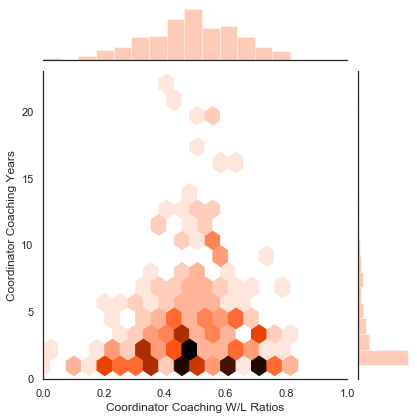

In [21]:
wvy_cc = sns.jointplot(x=lyp_piv.wl.Coordinator, y=lyp_piv.year.Coordinator, kind = 'hexa',xlim=(0,1), color = 'coral')
wvy_cc.set_axis_labels(xlabel = 'Coordinator Coaching W/L Ratios', ylabel='Coordinator Coaching Years')
plt.show()

#### Head Coach Year vs Winnig Ratio

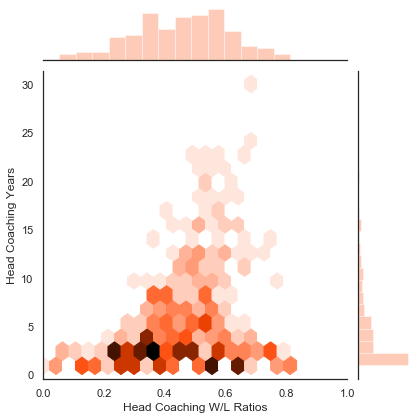

In [22]:
wvy_hh = sns.jointplot(x=lyp_piv.wl.Head, y=lyp_piv.year.Head, kind = 'hexa',xlim=(0,1), color = 'coral')
wvy_hh.set_axis_labels(xlabel = 'Head Coaching W/L Ratios', ylabel='Head Coaching Years')
plt.show()

## Win Ratios

#### Head Coach vs Coordinator

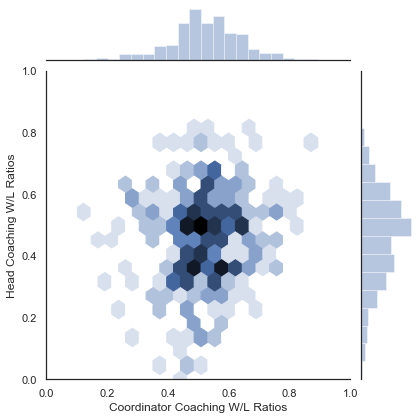

In [23]:
pvc_wl = sns.jointplot(x='Positional', y='Head', data= lp_pivot,kind = 'hexa',xlim=(0,1),ylim=(0,1))
sns.set(style="white")
pvc_wl.set_axis_labels(xlabel = 'Coordinator Coaching W/L Ratios', ylabel='Head Coaching W/L Ratios')
plt.show()

#### Head Coach vs Positional Coach

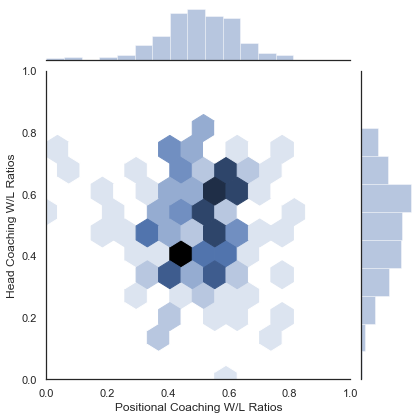

In [24]:
cvp_wl = sns.jointplot(x='Positional', y='Coordinator', data= lp_pivot,kind = 'hexa',xlim=(0,1),ylim=(0,1))
cvp_wl.set_axis_labels(xlabel = 'Positional Coaching W/L Ratios', ylabel='Head Coaching W/L Ratios')
plt.show()

#### Coordinator vs Positional Coach

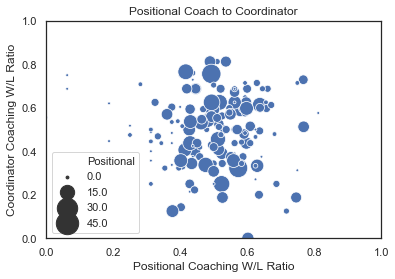

In [25]:
cvp_yrwl = sns.scatterplot(x = lyp_piv.wl.Positional, y=lyp_piv.wl.Coordinator, size=lyp_piv.year.Positional, sizes = (8,500))
cvp_yrwl.set(xlabel='Positional Coaching W/L Ratio', ylabel='Coordinator Coaching W/L Ratio',xlim=(0,1),ylim=(0,1))
cvp_yrwl.set_title('Positional Coach to Coordinator')
plt.show()

## Debuts

In [26]:
print('Coaches lasting for 3 or more years: ', len(head3))

Coaches lasting for 3 or more years:  341


In [27]:
print('Also worked in NFL for 3 or more years immediately prior: ',len(hp3))

Also worked in NFL for 3 or more years immediately prior:  191


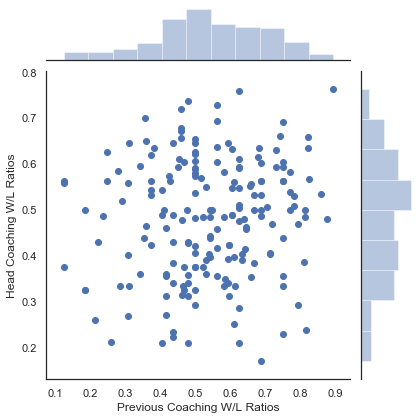

In [28]:
hp3_wl = sns.jointplot(x='wl_p', y='wl', data= hp3)
hp3_wl.set_axis_labels(xlabel = 'Previous Coaching W/L Ratios', ylabel='Head Coaching W/L Ratios')
plt.show()

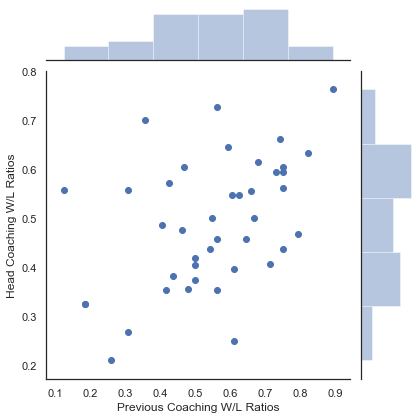

In [29]:
hp3_wl = sns.jointplot(x='wl_p', y='wl', data= hp3.loc[hp3.team==hp3.team_p])
hp3_wl.set_axis_labels(xlabel = 'Previous Coaching W/L Ratios', ylabel='Head Coaching W/L Ratios')
plt.show()

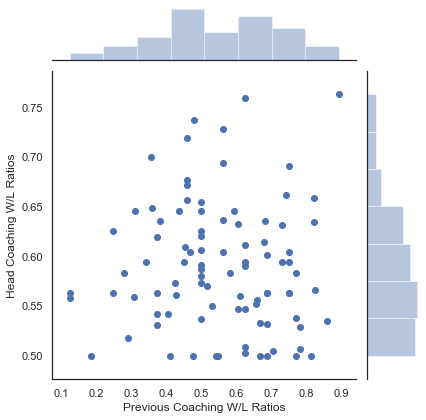

In [30]:
hp3_wl = sns.jointplot(x='wl_p', y='wl', data= hp3.loc[hp3.wl>=0.5])
hp3_wl.set_axis_labels(xlabel = 'Previous Coaching W/L Ratios', ylabel='Head Coaching W/L Ratios')
plt.show()

## Further Studies

### Study Effects of Phase background

### Trace coaches from college level

### Genealogy


## Erdo Number

In [31]:
are_related('Adam Gase','Andy Reid')

2
Green Bay Packers   1992


In [32]:
(person1,person2) = coaches['name'].sample(2)
print(person1)
print(person2)
are_related(person1,person2)

Frank Falks
Greg Olson
2
Detroit Lions   2004


In [33]:
are_related('Sid Gillman','Andy Reid')

3
Green Bay Packers   1996
